In [1]:
import pandas as pd
import FinanceDataReader as fdr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as optm

### cd91일 데이터 수집

In [5]:
# risk_free_rate data preprocessing
cd_3m = pd.read_excel('./cd_3m.xlsx').dropna()[3:]
cd_3m = cd_3m.reset_index()
cd_3m = cd_3m.drop('index', axis=1)
cd_3m.columns = ['Date', 'rf']
cd_3m['Date'] = pd.to_datetime(cd_3m['Date'].map(lambda x : x.replace('/', '-')))
cd_3m = cd_3m.set_index('Date')
cd_3m = cd_3m[cd_3m.index >= '2015-01-01']
cd_3m_d = cd_3m.applymap(lambda x : (x * 0.01) / 252)

### 코스피데이터수집

In [6]:
row = pd.read_excel('KOSPI200_STOCK.xlsx')
row = row[row['Date'] >= '2015-09-01'].dropna(axis=1)
row = row.set_index('Date')
row = row.applymap(lambda x : np.log(x)).diff().iloc[1:,:].dropna(axis=1)

row_cut = row[row.index < '2019-09-01']
row_cut= row_cut[row_cut.index >= '2015-09-02']

# 날짜 맞춰주기
cd_3m_d = pd.merge(row, cd_3m_d, how = 'left', left_index=True, right_index=True)['rf'].dropna()
cd_3m_d = pd.DataFrame(cd_3m_d)

risk_free_m = cd_3m_d.mean()

In [ ]:
"""
cons = [{'type':'ineq', 'fun': lambda x: x}, 
        {'type':'ineq', 'fun': lambda x: np.sum(x, 0)},   # row sum >= 0
        {'type':'ineq', 'fun': lambda x: 1 - np.sum(x, 0)},   # row sum <= 1
        {'type':'ineq', 'fun': lambda x: np.sum(x, 1) - 1},   # row sum >= 1
        {'type':'ineq', 'fun': lambda x: 1 - np.sum(x, 1)}]  # row sum <= 1
"""

### 각종 계산 함수

In [39]:
def Sigma(X):
    return X.cov()

def thresholded_cov(X, h=2):
    n, p = X.shape
    theta = np.zeros((p,p))
    
    Sig = Sigma(X)
    center = X - X.mean()
    
    for i in range(p):
        for j in range(i+1, p):
            theta[i,j] = np.mean((center.iloc[:,i]*center.iloc[:,j] - Sig.iloc[i,j])**2)
    
    Theta = theta + theta.T

    idx = Sig/np.sqrt(Theta) > h * np.sqrt(np.log(p)/n)
    return Sig * idx

def POET(X, num_eigen=10, lam = 1):
    n, p = X.shape
    w, v = np.linalg.eig(X.cov())
    factor_cov = v[:,:num_eigen] @ np.diag(w[:num_eigen]) @ v[:,:num_eigen].T
    
    sparse_input = Sigma(X) - factor_cov
    idx = np.zeros((p,p))

    #idx = i 변수와 j변수의 correlation의 절대값이 lambda보다 크면 1, 아니면 0
    for i in range(p):
        for j in range(p):
            idx[i,j] = 1 if sparse_input.iloc[i,j]/np.sqrt(sparse_input.iloc[i,i]*sparse_input.iloc[j,j]) >= 1 else 0
            
    sparse_cov = sparse_input*idx
    return factor_cov + sparse_cov

def objective(x, data, method, start_date, end_date, c, cov_mat):
    return x.T @ cov_mat @ x

def cons_pf_optm(data, method, start_date, end_date, c) :
    data = data[data.index < end_date]
    data = data[data.index >= start_date]
    cov_mat = method(data)
    # 초기값 random generate 
    # x0 = np.random.rand(185,1)
    # 초기값 1/n
    x0 =  [1/(data.shape[1])] * (data.shape[1])

    cons = [{'type':'eq', 'fun': lambda x: sum(x) - 1},
           {'type':'ineq', 'fun': lambda x:  -np.abs(x).sum() + c}]
    cons_pf = optm.minimize(objective, x0, constraints = cons,
                           args = (data, method, start_date, end_date, c, cov_mat),
                           options = {'maxiter':2})
    return cons_pf

def constraint_pf_ret(data, method, start_date, end_date, c) :
    data = data[data.index < end_date]
    data = data[data.index >= start_date]

    cons_pf = cons_pf_optm(data, method, start_date, end_date, c)
    cons_pf_ret = (row[row.index == end_date] * cons_pf.x).sum(axis = 1)
    return float(cons_pf_ret.values)

### rolling 시작 및 끝 날짜 계산

In [40]:
end_date_list = row[row.index >= '2019-09-02'].index.tolist()
start_date_list = row_cut.index.tolist()[:len(end_date_list)]

### constraint = 1, 2, 3 및 sample covariance를 통한 minimum variance portfolio 포트폴리오 수익률 계산

In [41]:
sample_c1_ret_list = []
sample_c2_ret_list = []
sample_c3_ret_list = []

for start_date, end_date in zip(start_date_list, end_date_list) :
    sample_c1_ret_list.append(constraint_pf_ret(row, Sigma, start_date, end_date, 1))
    sample_c2_ret_list.append(constraint_pf_ret(row, Sigma, start_date, end_date, 2))
    sample_c3_ret_list.append(constraint_pf_ret(row, Sigma, start_date, end_date, 3))
    print(end_date)

2019-09-02 00:00:00
2019-09-03 00:00:00
2019-09-04 00:00:00
2019-09-05 00:00:00
2019-09-06 00:00:00
2019-09-09 00:00:00
2019-09-10 00:00:00
2019-09-11 00:00:00
2019-09-16 00:00:00
2019-09-17 00:00:00
2019-09-18 00:00:00
2019-09-19 00:00:00
2019-09-20 00:00:00
2019-09-23 00:00:00
2019-09-24 00:00:00
2019-09-25 00:00:00
2019-09-26 00:00:00
2019-09-27 00:00:00
2019-09-30 00:00:00
2019-10-01 00:00:00
2019-10-02 00:00:00
2019-10-04 00:00:00
2019-10-07 00:00:00
2019-10-08 00:00:00
2019-10-10 00:00:00
2019-10-11 00:00:00
2019-10-14 00:00:00
2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-17 00:00:00
2019-10-18 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-04 00:00:00
2019-11-05 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00
2019-11-14 00:00:00


In [42]:
tmp = pd.DataFrame()
tmp['date'] = end_date_list
tmp = tmp.set_index('date')

tmp['sample_c1'] = sample_c1_ret_list
tmp['sample_c2'] = sample_c2_ret_list
tmp['sample_c3'] = sample_c3_ret_list

### constraint =1 및 threshold, poet 포트폴리오 수익률 계산

In [55]:
thres_c1_ret_list = []
poet_c1_ret_list = []

for start_date, end_date in zip(start_date_list, end_date_list) :
    thres_c1_ret_list.append(constraint_pf_ret(row, thresholded_cov, start_date, end_date, 1))
    poet_c1_ret_list.append(constraint_pf_ret(row, POET, start_date, end_date, 1))
    print(end_date)

2019-09-02 00:00:00
2019-09-03 00:00:00
2019-09-04 00:00:00
2019-09-05 00:00:00
2019-09-06 00:00:00
2019-09-09 00:00:00
2019-09-10 00:00:00
2019-09-11 00:00:00
2019-09-16 00:00:00
2019-09-17 00:00:00
2019-09-18 00:00:00
2019-09-19 00:00:00
2019-09-20 00:00:00
2019-09-23 00:00:00
2019-09-24 00:00:00
2019-09-25 00:00:00
2019-09-26 00:00:00
2019-09-27 00:00:00
2019-09-30 00:00:00
2019-10-01 00:00:00
2019-10-02 00:00:00
2019-10-04 00:00:00
2019-10-07 00:00:00
2019-10-08 00:00:00
2019-10-10 00:00:00
2019-10-11 00:00:00
2019-10-14 00:00:00
2019-10-15 00:00:00
2019-10-16 00:00:00
2019-10-17 00:00:00
2019-10-18 00:00:00
2019-10-21 00:00:00
2019-10-22 00:00:00
2019-10-23 00:00:00
2019-10-24 00:00:00
2019-10-25 00:00:00
2019-10-28 00:00:00
2019-10-29 00:00:00
2019-10-30 00:00:00
2019-10-31 00:00:00
2019-11-01 00:00:00
2019-11-04 00:00:00
2019-11-05 00:00:00
2019-11-06 00:00:00
2019-11-07 00:00:00
2019-11-08 00:00:00
2019-11-11 00:00:00
2019-11-12 00:00:00
2019-11-13 00:00:00
2019-11-14 00:00:00


In [98]:
tmp['thres_c1'] = thres_c1_ret_list
tmp['poet_c1'] = poet_c1_ret_list

In [99]:
tmp.to_excel('model_ret.xlsx')

### 모델별 포트폴리오 수익률 시각화

In [9]:
model_ret = pd.read_excel('model_ret.xlsx')
model_ret = model_ret.set_index('date')

equal_list = row.loc[model_ret.index.tolist(), :].applymap(lambda x: x/len(row.columns.tolist())).sum(axis=1)

model_ret['eqaul'] = equal_list
model_ret.iloc[0,:]  = model_ret.iloc[0,:] + 1

In [10]:
### 특이사항 eqault weight, sample_Covariance_c2, sample_Covariance_c2은 유사하게 나옴 
model_ret

,sample_c1,sample_c2,sample_c3,thres_c1,poet_c1,eqaul
date,,,,,,
2019-09-02,1.003444,1.003725,1.003725,1.003444,1.002220,1.003725
2019-09-03,0.003009,0.003560,0.003560,0.002954,0.003009,0.003560
2019-09-04,0.012467,0.008862,0.008862,0.012357,0.009222,0.008862
2019-09-05,0.010519,-0.002420,-0.002420,0.013283,0.010518,-0.002420
2019-09-06,0.002550,-0.002834,-0.002834,-0.002294,-0.002294,-0.002834
...,...,...,...,...,...,...
2020-09-10,0.005129,0.004223,0.004223,0.004599,0.004578,0.004264
2020-09-11,0.001296,0.001864,0.001864,0.001478,-0.000072,0.001628
2020-09-14,0.015658,0.013944,0.013944,0.014622,0.014237,0.013913


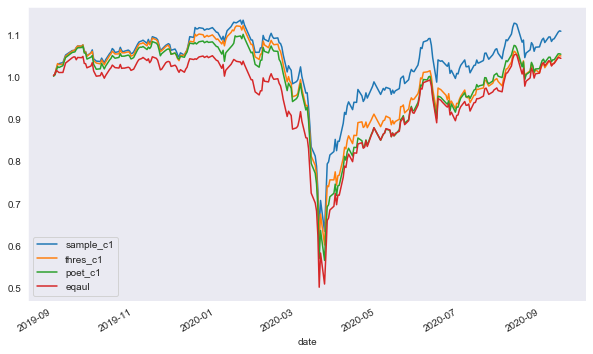

In [11]:
# 모델별 일별 수익률 plot
sns.set_style('dark')
model_ret[['sample_c1', 'thres_c1', 'poet_c1', 'eqaul']].cumsum().plot(figsize = (10,6))

### 모델별 Sharp Ratio 시각화

In [12]:
model_std = model_ret.iloc[1:,:].rolling(window = 30).std().dropna()

rf = cd_3m_d.loc[model_std.index, :]

# 데이터프레임 연산을 위한 risk free rate 데이터 전처리
rf['eqaul'] = rf.rf.tolist()
rf['sample_c1'] = rf.rf.tolist()
rf['sample_c2'] = rf.rf.tolist()
rf['sample_c3'] = rf.rf.tolist()
rf['thres_c1'] = rf.rf.tolist()
rf['poet_c1'] = rf.rf.tolist()
rf['eqaul'] = rf.rf.tolist()
rf = rf[['eqaul','sample_c1','sample_c2','sample_c3','thres_c1','poet_c1']]

model_sharp = (model_ret.sub(rf).dropna()).div(model_std)

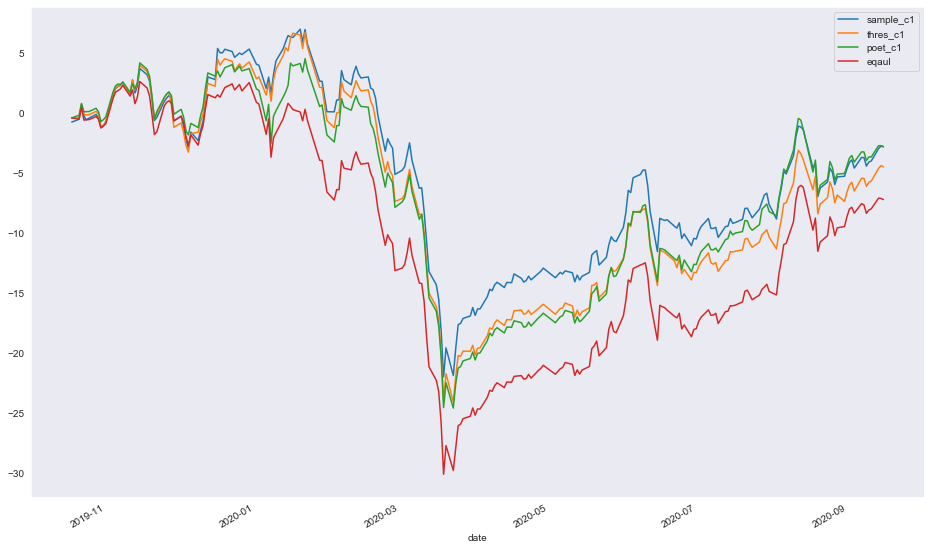

In [13]:
# 모델별 일별 sharp ratio plot
model_sharp[['sample_c1', 'thres_c1', 'poet_c1', 'eqaul']].cumsum().plot(figsize=(16,10))